In [1]:
%%time
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
torch.set_default_tensor_type('torch.cuda.FloatTensor')

CPU times: total: 1.98 s
Wall time: 2.07 s


In [2]:
df = pd.read_csv(r"C:\Users\akhil\Downloads\Alcohol_Sales.csv")

In [3]:
df.shape

(325, 2)

<AxesSubplot: >

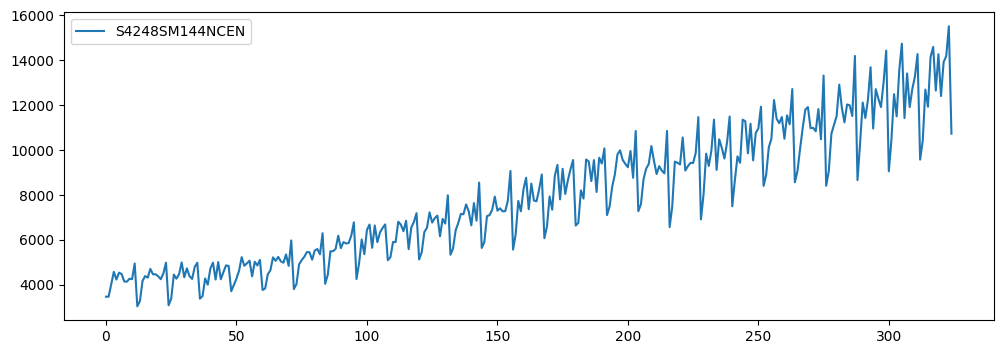

In [4]:
df.plot(figsize=(12,4))

In [5]:
y = df['S4248SM144NCEN'].values.astype(float)

In [6]:
test_size = 12
train_set = y[:-test_size]
test_set = y[-test_size:]

In [7]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [10]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [11]:
train_norm = scaler.transform(train_set.reshape(-1,1))

In [12]:
window_size = 12

In [13]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [14]:
window_size = 12

In [15]:
def input_data(seq,ws):
    out = list()
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [16]:
train_data = input_data(train_norm,window_size)

In [17]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743], device='cpu'),
 tensor([-1.], device='cpu'))

In [18]:
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_size=50,output_size=1):        
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,output_size)
        
        self.hidden = torch.stack((torch.zeros(1,1,hidden_size).to(device),torch.zeros(1,1,hidden_size).to(device)))
        
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq.to(device)),1,-1).to(device),
                                          self.hidden)
        
        pred = self.linear(lstm_out.view(len(seq),-1))
        
        return pred[-1]

In [19]:
device = torch.device('cpu')
model = LSTM()
model
torch.manual_seed(42)
PATH = "LSTM.pt"

# Save
torch.save(model.state_dict(), PATH)

# Load
device = torch.device('cuda')

In [20]:
torch.manual_seed(42)
model = LSTM()
model.load_state_dict(torch.load(PATH))
model.to(device)
model
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [23]:
epochs = 100
import time

start_time = time.time()
for epoch in range(epochs):
    
    for seq, y_train in train_data:
        
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred.to(device),y_train.to(device))
        
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch} Loss {loss.item()}")
        
total_time = time.time() - start_time
print(f"Time take to run the model is {total_time/60}")

Epoch 0 Loss 2.6363637447357178
Epoch 1 Loss 1.2316433191299438
Epoch 2 Loss 3.0401573181152344
Epoch 3 Loss 0.5597089529037476
Epoch 4 Loss 5.43972110748291
Epoch 5 Loss 0.1978527009487152
Epoch 6 Loss 3.456984043121338
Epoch 7 Loss 0.7235018014907837
Epoch 8 Loss 3.3791399002075195
Epoch 9 Loss 3.4413390159606934
Epoch 10 Loss 0.6844682097434998
Epoch 11 Loss 3.4866766929626465
Epoch 12 Loss 0.17514599859714508
Epoch 13 Loss 5.43009090423584
Epoch 14 Loss 0.5985307097434998
Epoch 15 Loss 2.999161958694458
Epoch 16 Loss 1.2787224054336548
Epoch 17 Loss 2.572427749633789
Epoch 18 Loss 4.1857590675354
Epoch 19 Loss 0.2705858647823334
Epoch 20 Loss 3.7672667503356934
Epoch 21 Loss 0.006931411102414131
Epoch 22 Loss 5.18048095703125
Epoch 23 Loss 1.1842411756515503
Epoch 24 Loss 2.426224708557129
Epoch 25 Loss 1.9015175104141235
Epoch 26 Loss 1.7823797464370728
Epoch 27 Loss 4.80280876159668
Epoch 28 Loss 0.038344014436006546
Epoch 29 Loss 3.852766990661621
Epoch 30 Loss 0.062231414020061

In [24]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

NameError: name 'preds' is not defined